# Comparative Analysis of Ensemble Methods for Predicting Antibody Titers

Author: Elias Dams

Date: 2 Dec 2024

Implement and Compare Ensemble Methods:
- Apply different ensemble learning techniques to predict antibody titers.
- Evaluate the performance of each method on individual datasets.
Identify the Best Predictive Model:
- Determine which method or combination of methods provides the highest accuracy.
- Assess whether integrating multiple data types improves predictions.

### Methods Overview
#### 1. Consensus Between Different Models
Description: Combine predictions from multiple models to reach a consensus decision. This can be achieved through techniques like majority voting for classification or averaging for regression tasks.
Purpose: To reduce individual model biases and variance by aggregating multiple model outputs, potentially leading to improved generalization on unseen data.

#### 2. Stacking Classifiers
Description: An ensemble technique where multiple base classifiers are trained, and a meta-classifier is then trained on their outputs to make the final prediction.
Purpose: To leverage the strengths of various algorithms by combining their predictions in a way that the meta-classifier can correct their individual weaknesses.

#### 3. Cascading Models:
Description: Sequentially apply models where the output of one model serves as the input for the next. This approach can be thought of as creating a pipeline of models that refine predictions progressively.
Purpose: To capture complex patterns by allowing subsequent models to learn from the residuals or errors of previous models, enhancing overall predictive capability.

#### 4. Multiple Kernel Learning
Description: An extension of kernel-based algorithms (e.g., Support Vector Machines) that utilizes multiple kernel functions to handle heterogeneous data sources. Each kernel can capture different data characteristics.
Purpose: To effectively integrate and learn from diverse data types by optimizing the combination of kernels, thereby improving model performance on complex datasets.



In [301]:
from mlxtend.evaluate import scoring
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
import numpy as np
from statsmodels.tools.sequences import primes_from_2_to
from tqdm import tqdm
from scipy.stats import mode
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample, shuffle
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.base import clone
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer

In [302]:
#### Config
LABELS = {'responder': {'name': 'response', 'color': 'blue'},
          'no response - high ab': {'name': 'no response - high ab', 'color': 'orange'},
          'no response - low ab':  {'name': 'no response - low ab', 'color': 'green'}
          }
COMPRESS_CORRELATED = False # compress correlated features
OVERSAMPLING_METHOD = "smote" # oversample the minority class ['remove', 'random', 'smote'] if None use balance accuracy
BALANCE = None # if "custom" Create custom class weights else balanced.
SAVE_FILE = "3_label_Consensus_5"
SAVE_DIR = "results/Measles"



In [303]:
# Load the antibody titers data (response profile)
abtiters = pd.read_csv('../data/Measles/antibody_df.csv')
print("Antibody titers data loaded. Shape:", abtiters.shape)
print(abtiters.head())

# Load the cytokines data
cytokines = pd.read_csv('../data/Measles/cytokines_data.csv')
print("Cytokines data loaded. Shape:", cytokines.shape)
print(cytokines.head())

# Load the cytometry data
cytometry = pd.read_csv('../data/Measles/cyto_data.csv')
print("Cytometry data loaded. Shape:", cytometry.shape)
print(cytometry.head())

# Load clonal breadth data
clonal_breadth = pd.read_csv('../data/Measles/clonal_breadth_data.csv')
print("Clonal breadth data loaded. Shape:", clonal_breadth.shape)
print(clonal_breadth.head())
# How many different TCR clonotypes (unique combinations of sequences, V/J genes, etc.) are specific to measles.

# Load clonal depth data
clonal_depth = pd.read_csv('../data/Measles/clonal_depth_data.csv')
print("Clonal depth data loaded. Shape:", clonal_depth.shape)
print(clonal_depth.head())
# The ratio of unique beta-chain sequences predicted to bind measles to the total number of clonotypes. 
# This focuses on the most important part of the TCR (the beta chain).

# Load the module scores
module_scores = pd.read_csv('../data/Measles/module_scores_model_input_all.csv') #calculate for Hepatitis B data
print("Module scores loaded. Shape:", module_scores.shape)
print(module_scores.head())

# Check the distribution of module scores
print("Module score columns:", module_scores.columns[1:10])

datasets = {
    "antibody_titers": abtiters,
    "cytokines": cytokines,
    "cytometry": cytometry,
    "clonal_breadth": clonal_breadth,
    "clonal_depth": clonal_depth,
    "RNa_data": module_scores,
}

Antibody titers data loaded. Shape: (40, 12)
        vaccine Vaccinee  Day 0  Day 21  Day 150  Day 365  diff: 21-0  \
0  Anti-Measles       M1    5.0   217.0     30.8     31.5       212.0   
1  Anti-Measles      M11   17.9    30.1    300.0    214.0        12.2   
2  Anti-Measles      M12  300.0   300.0    300.0    300.0         0.0   
3  Anti-Measles      M13  227.0   300.0    236.0    300.0        73.0   
4  Anti-Measles      M14   26.7   261.0    276.0    300.0       234.3   

   diff: 150-21  diff: 365-150  response  protected               quadrant  
0        -186.2            0.7      True       True              responder  
1         269.9          -86.0     False      False   no response - low ab  
2           0.0            0.0     False       True  no response - high ab  
3         -64.0           64.0     False       True  no response - high ab  
4          15.0           24.0      True       True              responder  
Cytokines data loaded. Shape: (40, 41)
  Vaccinee  CMV


Frequency of responses:
response_label
no response - low ab     15
no response - high ab    14
response                 11
Name: count, dtype: int64


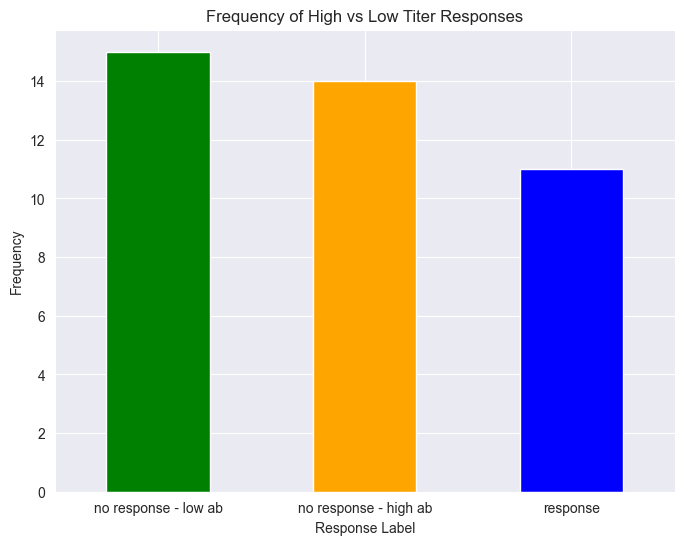

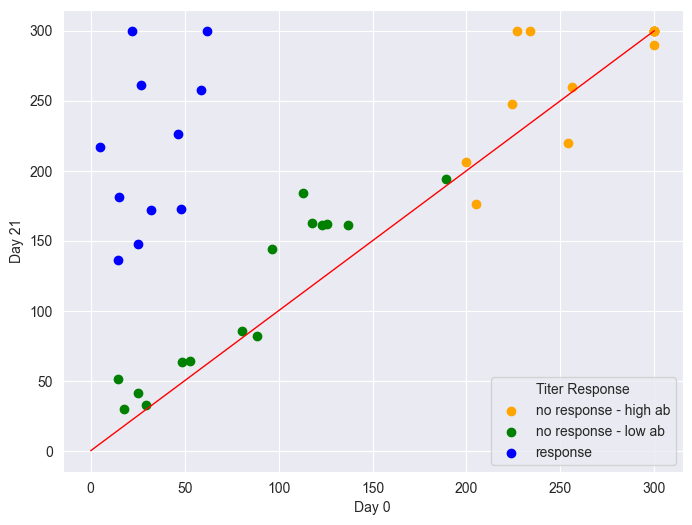

In [304]:
# Count the frequency of each label
abtiters['response_label'] = abtiters['quadrant'].replace({key: value['name'] for key, value in LABELS.items()})

# Count the frequency of each label
response_counts = abtiters['response_label'].value_counts()

print("\nFrequency of responses:")
print(response_counts)

converted_dict = {value['name']: value['color'] for value in LABELS.values()}

colors = [converted_dict[label] for label in response_counts.index]

# Plot the frequency of high vs. low responses as a bar plot
plt.figure(figsize=(8, 6))
response_counts.plot(kind='bar', color=colors)
plt.title('Frequency of High vs Low Titer Responses')
plt.xlabel('Response Label')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
for label, group in abtiters.groupby('response_label'):
    plt.scatter(group['Day 0'], group['Day 21'], color=converted_dict[label], label=label)

# Plot reference line y = x
plt.plot([0, max(abtiters['Day 0'])], [0, max(abtiters['Day 21'])], color='red', linestyle='-', linewidth=1)

# Labeling and legend
plt.xlabel('Day 0')
plt.ylabel('Day 21')
plt.legend(title="Titer Response")
plt.show()

In [305]:
abtiters = abtiters.drop(columns=['vaccine', 'Day 0', 'Day 21', 'Day 150', 'Day 365', 'diff: 21-0', 'diff: 150-21', 'diff: 365-150', 'response', 'protected','quadrant'])
## cytokines already loaded ##
cytometry = cytometry[['Vaccinee', 'WBC Day 0','RBC Day 0','HGB Day 0','HCT Day 0','PLT Day 0','%LYM Day 0','%MON Day 0','%GRA Day 0']]

datasets['antibody_titers'] = abtiters
datasets['cytometry'] = cytometry

### calculate a module score and comapare

In [306]:
def create_RNa_module_scores(read_count_path, module_scores_path, output_path_path):

    # Load data
    read_counts = pd.read_csv(read_count_path, index_col=0)  # Patients as rows, genes as columns
    module_list = pd.read_csv(module_scores_path)  # Contains columns 'Module', 'Gene', 'Function'
    
    # Ensure columns are strings for consistency
    read_counts.columns = read_counts.columns.astype(str)
    
    module_scores = []

    for module in module_list['Module'].unique():
        # Get the module's function
        module_function = module_list.loc[module_list['Module'] == module, 'Function'].iloc[0]
        module_genes = module_list[module_list['Module'] == module]['Gene']
        common_genes = [gene for gene in module_genes if gene in read_counts.columns]
    
        if not common_genes:
            print(f"No overlapping genes found for module {module}. Skipping.")
            continue
    
        # Subset read_counts for the genes in this module
        module_data = read_counts[common_genes]
        
        # Standardize the data
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(module_data)
        
        # Perform 1D PCA
        pca = PCA(n_components=1)
        pca_scores = pca.fit_transform(standardized_data)
        
        # Store results with module name and function
        module_scores.append(pd.DataFrame(
            pca_scores,
            index=read_counts.index,
            columns=[f"{module}.{module_function}"]
        ))
    
    # Combine all module scores into a single DataFrame
    module_scores_df = pd.concat(module_scores, axis=1)
    module_scores_df = module_scores_df.copy()
    
    # ---- pivoting logic -----
    
    # Extract 'Vaccinee' and 'TimePoint' from the index
    module_scores_df['TimePoint'] = module_scores_df.index.str.extract(r'_EXP(\d+)$', expand=False)
    module_scores_df['Vaccinee'] = module_scores_df.index.str.replace(r'_EXP\d+$', '', regex=True)
    
    # Reshape the data from long to wide format
    module_scores_df.reset_index(drop=True, inplace=True)  # Remove the old index
    wide_format = module_scores_df.pivot(index='Vaccinee', columns='TimePoint')
    
    # Flatten the MultiIndex in columns
    wide_format.columns = [
        f"{col[0]}_EXP{col[1]}" for col in wide_format.columns
    ]
    
    # Reset index to make 'Vaccinee' a column
    wide_format.reset_index(inplace=True)
    
    # Save the transformed data
    wide_format.to_csv(output_path_path, index=False)
    print(f"Transformed data saved as '{output_path_path}'")

In [307]:
create_RNa_module_scores(read_count_path = "../data/Measles/processed_readcounts_collapsed.csv", 
                         module_scores_path= "../data/Measles/module_list.csv", 
                         output_path_path= "../data/Measles/module_scores_model_input_all_self_made.csv")

rna_data = pd.read_csv("../data/Measles/module_scores_model_input_all_self_made.csv")
datasets["RNa_data"] = rna_data

Transformed data saved as '../data/Measles/module_scores_model_input_all_self_made.csv'


In [308]:
# get only the EXP0 cols:
# Filter columns to keep only those containing "_EXP0"
rna_data_exp0 = rna_data.loc[:, (rna_data.columns == "Vaccinee") | (rna_data.columns.str.contains("_EXP0"))]
datasets["RNa_data"] = rna_data_exp0

# Optionally, view the resulting DataFrame
print(rna_data_exp0.head())

  Vaccinee  M3.1.Cell cycle_EXP0  M8.1.TBD_EXP0  M8.2.Prostanoids_EXP0  \
0       M1             -2.522262      -0.484210              -3.907561   
1      M11             -4.182731      -0.059521               1.248508   
2      M12              1.397387      -2.213685              -2.496329   
3      M13              2.388776       0.363241               1.128747   
4      M14             -2.284118       0.821419              -2.012061   

   M8.3.Type 1 Interferon_EXP0  M9.1.Cytotoxic lymphocytes_EXP0  \
0                    -1.750826                         3.529086   
1                     0.077094                        -7.191759   
2                    -1.332382                         2.076533   
3                    -1.481503                         1.499603   
4                    -3.022494                        -3.224243   

   M9.2.Erythroid cells_EXP0  M10.1.Interferon_EXP0  \
0                  -2.774529              -0.980424   
1                  -4.818251              

### 1. Consensus Between Different Models

In [309]:
# Merge datasets with the labels
cytokines_merged = pd.merge(datasets['antibody_titers'], datasets['cytokines'], on='Vaccinee')
cytometry_merged = pd.merge(datasets['antibody_titers'], datasets['cytometry'], on='Vaccinee')
clonal_breadth_merged = pd.merge(datasets['antibody_titers'], datasets['clonal_breadth'], on='Vaccinee') #for now because they only contain 27 values
clonal_depth_merged = pd.merge(datasets['antibody_titers'], datasets['clonal_depth'], on='Vaccinee') #for now because they only contain 27 values
rna_merged = pd.merge(datasets['antibody_titers'], datasets['RNa_data'], on='Vaccinee')

In [310]:
# Function to check missing values
def check_missing_values(df, dataset_name):
    nr_samples = len(datasets['antibody_titers']['Vaccinee'])
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    
    print(f"{dataset_name}:")
    
    if len(df['Vaccinee']) < nr_samples:
        print(f"\tMissing samples: only contains {len(df['Vaccinee'])} samples instead of {nr_samples}.") 
        
    
    if not missing.empty:
        print(f"\tMissing values:")
        print(f"\t{missing}")
    else:
        print(f"\tNo missing values.")

# Check for missing values
check_missing_values(cytokines_merged, 'Cytokines Merged')
check_missing_values(cytometry_merged, 'Cytometry Merged')
check_missing_values(clonal_breadth_merged, 'Clonal Breadth Merged')
check_missing_values(clonal_depth_merged, 'Clonal Depth Merged')
check_missing_values(rna_merged, 'RNA Merged')

Cytokines Merged:
	No missing values.
Cytometry Merged:
	No missing values.
Clonal Breadth Merged:
	Missing samples: only contains 27 samples instead of 40.
	No missing values.
Clonal Depth Merged:
	Missing samples: only contains 27 samples instead of 40.
	No missing values.
RNA Merged:
	No missing values.


In [311]:
def handle_missing_values(df, dataset_name, complete_samples, strategy='mean'):
    print(f"Handling missing values for {dataset_name}...")
    new_df = df.copy()

    # Identify missing samples
    missing_samples = complete_samples[~complete_samples['Vaccinee'].isin(df['Vaccinee'])]
    if missing_samples.empty:
        print(f"\tNo missing samples to add for {dataset_name}.")
        return new_df

    print(f"\tFound {len(missing_samples)} missing samples to process.")

    # Function to prepare training subset
    def prepare_training_subset(label, df):
        if pd.notnull(label):
            subset = df[df['response_label'] == label].drop(['Vaccinee', 'response_label'], axis=1)
            return subset if not subset.empty else df.drop(['Vaccinee', 'response_label'], axis=1)
        return df.drop(['Vaccinee', 'response_label'], axis=1)

    # Imputation logic
    imputed_features_list = []
    imputer_class = KNNImputer if strategy.lower() == 'knn' else SimpleImputer
    imputer_kwargs = {'strategy': strategy} if strategy.lower() != 'knn' else {'n_neighbors': 3}

    for label, group in missing_samples.groupby('response_label'):
        # Prepare training subset
        train_subset = prepare_training_subset(label, df)
        
        # Ensure all columns in train_subset exist in the group
        features = group[['Vaccinee', 'response_label']].copy()  # Keep 'Vaccinee' and 'response_label' intact
        for col in train_subset.columns:
            if col not in features.columns:
                features[col] = None  # Add missing columns with None
        
        # Drop 'Vaccinee' and 'response_label' for imputation
        imputation_input = features.drop(['Vaccinee', 'response_label'], axis=1)
        
        # Impute missing values
        imputer = imputer_class(**imputer_kwargs)
        imputer.fit(train_subset)
        imputed_values = imputer.transform(imputation_input)
        
        # Add imputed values back to the features DataFrame
        for i, col in enumerate(imputation_input.columns):
            features[col] = imputed_values[:, i]
        
        imputed_features_list.append(features)

    # Combine all imputed groups
    imputed_features = pd.concat(imputed_features_list, axis=0).reset_index(drop=True)

    # Append imputed samples to the original dataframe
    new_df = pd.concat([df, imputed_features], ignore_index=True)
    new_df = new_df.set_index('Vaccinee').reindex(complete_samples['Vaccinee']).reset_index()
    print(f"\tAdded {len(imputed_features)} samples to {dataset_name}.")

    return new_df

cytokines_merged = handle_missing_values(cytokines_merged, 'Cytokines Merged', datasets['antibody_titers'], strategy='mean')
cytometry_merged = handle_missing_values(cytometry_merged, 'Cytometry Merged', datasets['antibody_titers'], strategy='mean')
clonal_breadth_merged =handle_missing_values(clonal_breadth_merged, 'Clonal Breadth Merged', datasets['antibody_titers'], strategy='mean')
clonal_depth_merged = handle_missing_values(clonal_depth_merged, 'Clonal Depth Merged', datasets['antibody_titers'], strategy='mean')
rna_merged = handle_missing_values(rna_merged, 'RNA Merged', datasets['antibody_titers'], strategy='mean')

Handling missing values for Cytokines Merged...
	No missing samples to add for Cytokines Merged.
Handling missing values for Cytometry Merged...
	No missing samples to add for Cytometry Merged.
Handling missing values for Clonal Breadth Merged...
	Found 13 missing samples to process.
	Added 13 samples to Clonal Breadth Merged.
Handling missing values for Clonal Depth Merged...
	Found 13 missing samples to process.
	Added 13 samples to Clonal Depth Merged.
Handling missing values for RNA Merged...
	No missing samples to add for RNA Merged.


In [312]:
def compress_correlated_features(data, groups):
    """
    Compress groups of highly correlated features into a single principal component for each group.
    
    Parameters:
    - data (pd.DataFrame): The input dataframe containing the features.
    - groups (dict): A dictionary where keys are group names and values are lists of correlated features.
    
    Returns:
    - data (pd.DataFrame): The dataframe with compressed features added and original features removed.
    """
    def compress_features(data, features, new_feature_name):
        # Standardize the features
        scaler = StandardScaler()
        standardized_features = scaler.fit_transform(data[features])
        
        # Perform PCA to extract the first principal component
        pca = PCA(n_components=1)
        principal_component = pca.fit_transform(standardized_features)
        
        # Add the new compressed feature to the dataframe
        data[new_feature_name] = principal_component
        return data

    # Iterate over each group and compress the features
    for group_name, features in groups.items():
        new_feature_name = f"{group_name}_Compressed"
        data = compress_features(data, features, new_feature_name)

    # Drop the original features that were compressed
    all_features_to_drop = [feature for group in groups.values() for feature in group]
    data.drop(columns=all_features_to_drop, inplace=True)
    
    return data

if COMPRESS_CORRELATED:
    # Define the groups of correlated features cytokines
    cytokines_groups = {
        'Group_1': ['TNFb', 'IL-13', 'MCP3', 'IL1Ra'],
        'Group_2': ['IL-2', 'GM-CSF', 'IL-10', 'IL-9', 'IFNa2', 'IL-7'],
        'Group_3': ['TNFa', 'TGF-a', 'IL17A', 'IFNg', 'IL12-p70', 'MIP1b', 'FGF-2'], # 'Flt3 Ligand', 'VEGF'
        'Group_4': ['Fractalkine', 'IL-15', 'IL-1b' ]
    }
    
    cytokines_merged = compress_correlated_features(cytokines_merged, cytokines_groups)
    
    # Define the groups of correlated features cytokines
    cytometry_groups = {
        'Group_1': ['RBC Day 0', 'HGB Day 0', 'HCT Day 0'],
        'Group_2': ['%LYM Day 0', '%GRA Day 0']
    }
    
    cytometry_merged = compress_correlated_features(cytometry_merged, cytometry_groups)


In [313]:
def encode_labels(df):
    le = LabelEncoder()
    df['response_label'] = le.fit_transform(df['response_label'])
    return df

# Encode labels if necessary
cytokines_merged = encode_labels(cytokines_merged)
cytometry_merged = encode_labels(cytometry_merged)
clonal_breadth_merged = encode_labels(clonal_breadth_merged)
clonal_depth_merged = encode_labels(clonal_depth_merged)
rna_merged = encode_labels(rna_merged)

In [314]:
# Let's get the list of vaccinees to use as indices

# to just shiffle randomly
vaccinees = abtiters['Vaccinee']
train_vaccinees, test_vaccinees = train_test_split(vaccinees, test_size=0.2, random_state=42, stratify=abtiters['response_label'])


def split_dataset(df, oversampling_method = None):
    # Use the pre-defined train and test vaccinees
    train_df = df[df['Vaccinee'].isin(train_vaccinees)]
    test_df = df[df['Vaccinee'].isin(test_vaccinees)]
    
    # Separate features and labels
    X_train = train_df.drop(['Vaccinee', 'response_label'], axis=1)
    y_train = train_df['response_label']
    X_test = test_df.drop(['Vaccinee', 'response_label'], axis=1)
    y_test = test_df['response_label']
    
    X_train_resampled = X_train
    y_train_resampled = y_train
    
    if oversampling_method is not None:
        if oversampling_method == 'smote':
            # Perform oversampling on the training data
            sm = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
        
        elif oversampling_method == 'random':
            # Perform random oversampling on the training data (simply duplicates existing minority class samples)
            ros = RandomOverSampler(random_state=42)
            X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
        
        elif oversampling_method == 'remove':
            # Perform random undersampling on the majority class
            majority_class = Counter(y_train).most_common(1)[0][0]  # Get the majority class label
            minority_class = [cls for cls in set(y_train) if cls != majority_class][0]  # Get minority class label
            
            # Separate majority and minority classes
            X_majority = X_train[y_train == majority_class]
            y_majority = y_train[y_train == majority_class]
            X_minority = X_train[y_train == minority_class]
            y_minority = y_train[y_train == minority_class]
            
            # Downsample majority class to match minority class size
            X_majority_downsampled, y_majority_downsampled = resample(
                X_majority, y_majority,
                replace=False,
                n_samples=len(y_minority),
                random_state=42
            )
            
            # Identify the removed majority class samples
            # Use index to ensure accurate removal
            removed_indices = X_majority.index.difference(X_majority_downsampled.index)
            X_majority_removed = X_majority.loc[removed_indices]
            y_majority_removed = y_majority.loc[removed_indices]
            
            # Combine downsampled majority class with the minority class
            X_train_resampled = pd.concat([X_majority_downsampled, X_minority])
            y_train_resampled = pd.concat([y_majority_downsampled, y_minority])
            
            # Add the removed samples to the rest set
            # Concatenate features and labels for the rest set
            removed_samples = pd.concat([X_majority_removed, y_majority_removed], axis=1)
            X_rest = removed_samples.drop(['response_label'], axis=1)
            y_rest = removed_samples['response_label']
            X_test = pd.concat([X_test,X_rest])
            y_test = pd.concat([y_test,y_rest])
        
        else:
            raise ValueError(f"Unsupported oversampling method: {oversampling_method}")
    
        
                
        # After oversampling
        print(f"Resampled class distribution using {oversampling_method} for train set: {Counter(y_train_resampled)}")
        print(f"Resampled class distribution using {oversampling_method} for test set: {Counter(y_test)}")
    else:
        # No oversampling
        print(f"Class distribution for train set: {Counter(y_train_resampled)}")
        print(f"Class distribution for test set: {Counter(y_test)}")
    
        
    
    return X_train_resampled, X_test, y_train_resampled, y_test

# Split each dataset
X_train_cyto, X_test_cyto, y_train_cyto, y_test_cyto = split_dataset(cytokines_merged, oversampling_method=OVERSAMPLING_METHOD)
X_train_cytom, X_test_cytom, y_train_cytom, y_test_cytom = split_dataset(cytometry_merged,oversampling_method=OVERSAMPLING_METHOD)
X_train_cb, X_test_cb, y_train_cb, y_test_cb = split_dataset(clonal_breadth_merged, oversampling_method=OVERSAMPLING_METHOD)
X_train_cd, X_test_cd, y_train_cd, y_test_cd = split_dataset(clonal_depth_merged, oversampling_method=OVERSAMPLING_METHOD)
X_train_rna, X_test_rna, y_train_rna, y_test_rna = split_dataset(rna_merged, oversampling_method=OVERSAMPLING_METHOD)


Resampled class distribution using smote for train set: Counter({2: 12, 1: 12, 0: 12})
Resampled class distribution using smote for test set: Counter({0: 3, 1: 3, 2: 2})
Resampled class distribution using smote for train set: Counter({2: 12, 1: 12, 0: 12})
Resampled class distribution using smote for test set: Counter({0: 3, 1: 3, 2: 2})
Resampled class distribution using smote for train set: Counter({2: 12, 1: 12, 0: 12})
Resampled class distribution using smote for test set: Counter({0: 3, 1: 3, 2: 2})
Resampled class distribution using smote for train set: Counter({2: 12, 1: 12, 0: 12})
Resampled class distribution using smote for test set: Counter({0: 3, 1: 3, 2: 2})
Resampled class distribution using smote for train set: Counter({2: 12, 1: 12, 0: 12})
Resampled class distribution using smote for test set: Counter({0: 3, 1: 3, 2: 2})


In [315]:
scaler = StandardScaler()

def scale_features(X_train, X_test):
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Scale features
X_train_cyto_scaled, X_test_cyto_scaled = scale_features(X_train_cyto, X_test_cyto)
X_train_cytom_scaled, X_test_cytom_scaled = scale_features(X_train_cytom, X_test_cytom)
X_train_cb_scaled, X_test_cb_scaled = scale_features(X_train_cb, X_test_cb)
X_train_cd_scaled, X_test_cd_scaled = scale_features(X_train_cd, X_test_cd)
X_train_rna_scaled, X_test_rna_scaled = scale_features(X_train_rna, X_test_rna)

In [316]:

from sklearn.utils import compute_class_weight
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import f1_score, make_scorer

import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from collections import defaultdict

def custom_loo_metrics(model, X, y):
    """
    Custom Leave-One-Out Cross-Validation function to calculate Precision, Recall, F1 Score, and Balanced Accuracy for multiple classes.

    Parameters:
    - model: The model to be used for cross-validation.
    - X: Feature matrix (training data).
    - y: Target vector (labels).

    Returns:
    - metrics: Dictionary containing metrics (Precision, Recall, F1 Score, Balanced Accuracy) per class.
    """
    # Initialize the Leave-One-Out cross-validation strategy
    loo = LeaveOneOut()
    
    # Get unique classes
    classes = np.unique(y)
    
    # Initialize dictionaries to track TP, FP, FN for each class
    metrics_tracker = {
        cls: {'TP': 0, 'FP': 0, 'FN': 0} for cls in classes
    }
    
    build_in_cross_val = cross_val_score(model, X, y, cv=loo, scoring="accuracy")
    custom_cross_val = []
    
    # Perform cross-validation
    for train_index, test_index in loo.split(X):
        # Split data into training and testing sets for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train the model on the training set
        model.fit(X_train, y_train)

        # Make a prediction on the test sample (this is where the leave-one-out happens)
        y_pred = model.predict(X_test)

        # Ensure that y_test and y_pred are 1D arrays
        y_pred = np.array(y_pred).flatten()
        y_true = np.array(y_test).flatten()

        correct = int(y_pred[0] == y_true[0])  # Convert boolean to 1 or 0
        custom_cross_val.append(correct)
    
        # Update TP, FP, FN for each class
        for cls in classes:
            if y_true[0] == cls:
                if y_pred[0] == cls:
                    metrics_tracker[cls]['TP'] += 1
                else:
                    metrics_tracker[cls]['FN'] += 1
                    metrics_tracker[y_pred[0]]['FP'] += 1
            else:
                if y_pred[0] == cls:
                    metrics_tracker[cls]['FP'] += 1
                # No action needed for TN in per-class metrics
                
    # Sanity check comparison
    if not np.all(build_in_cross_val == custom_cross_val):
        raise ValueError("Sanity check failed! There is a mismatch in the calculated accuracy.")
    
    # Calculate precision, recall, and F1 score for each class
    precision = {}
    recall = {}
    f1_score = {}
    
    for cls in classes:
        tp = metrics_tracker[cls]['TP']
        fp = metrics_tracker[cls]['FP']
        fn = metrics_tracker[cls]['FN']
        
        precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score[cls] = (2 * precision[cls] * recall[cls]) / (precision[cls] + recall[cls]) if (precision[cls] + recall[cls]) > 0 else 0
    
    # Calculate balanced accuracy
    balanced_accuracy = np.mean(list(recall.values()))
    
    # Calculate overall accuracy
    accuracy = np.mean(custom_cross_val)
    
    # Compile all metrics into a dictionary
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1': f1_score,
        'Balanced_Accuracy': balanced_accuracy,
        'Accuracy': accuracy
    }
    
    return metrics

def train_and_predict_best_model(X_train, y_train, X_test, data_name, results_dir='../data_created/best_models'):
    """
    Trains multiple models, evaluates them using balanced accuracy, AUC, F1 score, permutation tests, 
    and bootstrap confidence intervals. Selects the best model based on balanced accuracy and writes the evaluation results to a CSV file.

    Parameters:
    - X_train (pd.DataFrame or np.ndarray): Training features.
    - y_train (pd.Series or np.ndarray): Training labels.
    - X_test (pd.DataFrame or np.ndarray): Testing features.
    - data_name (str): Name of the dataset (used for labeling outputs).
    - results_dir (str): Directory where result files will be saved.

    Returns:
    - y_pred (np.ndarray): Predictions on the test set using the best model.
    - best_model_name (str): Name of the best model.
    - best_model (estimator): The best trained model instance.
    """
    import warnings
    warnings.filterwarnings('ignore')

    # Ensure results directory exists
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        
    if BALANCE == 'custom':
        unique, counts = np.unique(y_train, return_counts=True)
        # Identify the majority class count
        max_count = counts.max()
        # Create custom class weights
        custom_class_weights = {
            label: (1/count)*max_count for label, count in zip(unique, counts)
        }
    else:
        balanced_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        # normal balanced
        custom_class_weights = dict(zip(np.unique(y_train), balanced_weights))
    print(custom_class_weights)

    # Define models with balanced class weights where applicable
    models = {
        'Random Forest': RandomForestClassifier(random_state=42, class_weight=custom_class_weights),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight=custom_class_weights),
        'SVM': SVC(random_state=42, class_weight=custom_class_weights, probability=True),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight=custom_class_weights),
        'Naive Bayes': GaussianNB()
    }

    # Initialize a list to store evaluation results
    evaluation_results = []

    # Iterate through each model
    for name, model in models.items():

        # Clone the model to ensure independence
        cloned_model = clone(model)

        # Cross-validation for balanced accuracy, F1, and AUC
        metrics = custom_loo_metrics(cloned_model, X_train.copy(), y_train.copy())

        # Append the results
        evaluation_results.append({
            'Model': name,
            **metrics
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(evaluation_results)
    
    def flatten_metrics(df, metric_name, classes):
        for cls in classes:
            df[f'{metric_name}_{cls}'] = df[metric_name].apply(lambda x: x.get(cls, 0))
        df.drop(columns=[metric_name], inplace=True)
        return df
    
    def generate_dynamic_weights(metric_weights, classes):
        weights = {}

        for cls in classes:
            for metric in ['Precision', 'Recall', 'F1']:
                base_metric = metric.replace('_Score', '')  # Convert 'F1_Score' to 'F1'
                weight = metric_weights.get(base_metric, 0)
                weights[f"{metric}_{cls}"] = weight
        
        # Assign weights to scalar metrics
        for scalar_metric in ['Balanced_Accuracy', 'Accuracy']:
            weights[scalar_metric] = metric_weights.get(scalar_metric, 0)
        
        return weights
    
    classes = np.unique(y_train)
    # Flatten 'Precision', 'Recall', and 'F1'
    results_df = flatten_metrics(results_df, 'Precision',classes)
    results_df = flatten_metrics(results_df, 'Recall', classes)
    results_df = flatten_metrics(results_df, 'F1', classes)
    
    # Save the evaluation results to a CSV file
    results_file = os.path.join(results_dir, f"{data_name}_model_evaluation.csv")
    results_df.to_csv(results_file, index=False)
    print(f"Model evaluation results saved to {results_file}")
    
    metric_weights = {
        'Precision': 0,      # Precision for class
        'Recall': 0,         # Recall for class
        'F1': 2,             # F1 score for class 
        'Balanced_Accuracy': 4, # Higher weight for Balanced Accuracy
        'Accuracy': 0          # Accuracy weight
    }
    
    weights = generate_dynamic_weights(metric_weights, classes)
    
    # Calculate the composite score for each model
    # Ensure that all weight keys exist in the DataFrame
    missing_weights = set(weights.keys()) - set(results_df.columns)
    if missing_weights:
        raise ValueError(f"The following weight keys are missing in the results DataFrame: {missing_weights}")
    
    # Identify metric columns to include in composite score calculation
    metric_columns = list(weights.keys())
    
    # Calculate the composite score
    results_df['Composite_Score'] = results_df[metric_columns].multiply(weights, axis=1).sum(axis=1)
    
    # Find the model with the highest composite score
    best_model_row = results_df.loc[results_df['Composite_Score'].idxmax()]
    
    # Get the name of the best model and its metrics
    best_model_name = best_model_row['Model']
    best_model_metrics = best_model_row.to_dict()
    
    # Clone the model from the models dictionary
    model = clone(models[best_model_name])
    model.fit(X_train, y_train)
    
    # Predict on the test set using the current model
    y_pred = model.predict(X_test)

    # Filter out metrics with weight 0
    filtered_metrics = {key: value for key, value in best_model_metrics.items() if key not in ['Model', 'Composite_Score'] and weights[key] > 0}
    
    # Convert the filtered metrics to DataFrame
    best_model_df = pd.DataFrame([filtered_metrics])
    best_model_df.insert(0, 'Model', best_model_name)  # Add model name to the DataFrame
    
    # Print the best model and its metrics
    print("\nBest Model and Its Metrics (Only Weighted Metrics > 0):")
    print(best_model_df)
    
    return y_pred, best_model_name, model, best_model_metrics

y_pred_cyto, best_model_name_cyto, best_model_cyto, train_metrics_cyto = train_and_predict_best_model(X_train_cyto_scaled, y_train_cyto, X_test_cyto_scaled, "Cytokines")
y_pred_cytom, best_model_name_cytom, best_model_cytom, train_metrics_cytom = train_and_predict_best_model(X_train_cytom_scaled, y_train_cytom, X_test_cytom_scaled,"Cytometry")
y_pred_cb, best_model_name_cb, best_model_cb, train_metrics_cb = train_and_predict_best_model(X_train_cb_scaled, y_train_cb, X_test_cb_scaled,"Clonal_Breadth")
y_pred_cd, best_model_name_cd, best_model_cd, train_metrics_cd = train_and_predict_best_model( X_train_cd_scaled, y_train_cd, X_test_cd_scaled,"Clonal_Depth")
y_pred_rna, best_model_name_rna, best_model_rna, train_metrics_rna= train_and_predict_best_model(X_train_rna_scaled, y_train_rna, X_test_rna_scaled,"RNA")

{np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}
Model evaluation results saved to ../data_created/best_models/Cytokines_model_evaluation.csv

Best Model and Its Metrics (Only Weighted Metrics > 0):
                 Model  Balanced_Accuracy      F1_0      F1_1      F1_2
0  Logistic Regression           0.416667  0.285714  0.545455  0.222222
{np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}
Model evaluation results saved to ../data_created/best_models/Cytometry_model_evaluation.csv

Best Model and Its Metrics (Only Weighted Metrics > 0):
         Model  Balanced_Accuracy     F1_0      F1_1      F1_2
0  Naive Bayes           0.583333  0.37037  0.461538  0.588235
{np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0), np.int64(2): np.float64(1.0)}
Model evaluation results saved to ../data_created/best_models/Clonal_Breadth_model_evaluation.csv

Best Model and Its Metrics (Only Weighted Metrics > 0):
  

In [317]:
import numpy as np
from scipy.stats import mode
from sklearn.metrics import balanced_accuracy_score
from sklearn.base import clone
from collections import defaultdict

def ensemble_consensus(y_preds, model_balanced_accuracies):
    if len(y_preds) != len(model_balanced_accuracies):
        raise ValueError("Number of prediction arrays must match number of model accuracies.")
    
    n_models = len(y_preds)
    n_samples = y_preds[0].shape[0]
    
    # Stack predictions: shape (n_samples, n_models)
    predictions = np.column_stack(y_preds)
    
    # Initialize consensus predictions array
    y_pred_consensus = np.empty(n_samples, dtype=y_preds[0].dtype)
    
    # Iterate over each sample
    for i in range(n_samples):
        sample_preds = predictions[i]
        unique_classes, counts = np.unique(sample_preds, return_counts=True)
        
        # Find the maximum vote count
        max_count = counts.max()
        classes_with_max = unique_classes[counts == max_count]
        
        if len(classes_with_max) == 1:
            # No tie, assign the majority class
            y_pred_consensus[i] = classes_with_max[0]
        else:
            # Tie detected, proceed to tie-breaking
            # Calculate weighted votes for each tied class
            weighted_votes = defaultdict(float)
            for cls in classes_with_max:
                # Identify which models predicted this class
                model_indices = np.where(sample_preds == cls)[0]
                # Sum the weights of these models
                weighted_votes[cls] = model_balanced_accuracies[model_indices].sum()
            
            # Select the class with the highest weighted vote
            # In case of further tie, select the class with the highest overall balanced accuracy
            max_weight = max(weighted_votes.values())
            classes_with_max_weight = [cls for cls, wt in weighted_votes.items() if wt == max_weight]
            
            if len(classes_with_max_weight) == 1:
                y_pred_consensus[i] = classes_with_max_weight[0]
            else:
                # Further tie-breaking: select the class with the highest overall balanced accuracy
                # Assuming 'overall_balanced_accuracy_per_class' is a dict with class-wise balanced accuracies
                # You need to provide this information
                # For this example, we'll default to the first class
                # Replace this with actual class-wise balanced accuracies if available
                y_pred_consensus[i] = classes_with_max_weight[0]
                print(f"Sample {i}: Further tie between classes {classes_with_max_weight}. Defaulting to class {classes_with_max_weight[0]}.")
    
    return y_pred_consensus

if len(np.unique(y_train_cb)) > 2:
    # Define weights for each model (example weights)
    model_balanced_accuracies = np.array([
        float(train_metrics_cyto['Balanced_Accuracy']),
        float(train_metrics_cytom['Balanced_Accuracy']),
        float(train_metrics_cb['Balanced_Accuracy']),
        float(train_metrics_cd['Balanced_Accuracy']),
        float(train_metrics_rna['Balanced_Accuracy'])
    ]) # Adjust based on model performance
    
    # Stack predictions
    predictions = [y_pred_cyto, y_pred_cytom, y_pred_cb, y_pred_cd, y_pred_rna]
    
    y_pred_consensus = ensemble_consensus(predictions,model_balanced_accuracies)
else:
    # Stack predictions from different models
    predictions = np.column_stack((y_pred_cyto, y_pred_cytom, y_pred_cb, y_pred_cd, y_pred_rna))  

    # Compute mode and counts
    y_pred_consensus, _ = mode(predictions, axis=1)
    y_pred_consensus = y_pred_consensus.ravel()

In [318]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

def evaluate_model(y_true, y_pred, model_name):
    print(f"\n=== Evaluation Metrics for {model_name} ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}")

In [319]:
y_test = y_test_cyto.values # Because they are all e the same

In [320]:
# Evaluate separate models
evaluate_model(y_test, y_pred_cyto, 'Cytokines Model')
evaluate_model(y_test, y_pred_cytom, 'Cytometry Model')
evaluate_model(y_test, y_pred_cb, 'Clonal Breadth Model')
evaluate_model(y_test, y_pred_cd, 'Clonal Depth Model')
evaluate_model(y_test, y_pred_rna, 'RNA Data Model')

# Evaluate consensus model
evaluate_model(y_test, y_pred_consensus, 'Consensus Model')

print(f"truth:\t\t { y_test_cyto.values }")
print(f"cytokines: { y_pred_cyto }")
print(f"cytometry: { y_pred_cytom }")
print(f"clonal b.: { y_pred_cb }")
print(f"clonal D.: { y_pred_cd }")
print(f"rna:\t\t\t { y_pred_rna }")
print(f"Consensus: { y_pred_consensus }")



=== Evaluation Metrics for Cytokines Model ===
Confusion Matrix:
[[0 1 2]
 [0 3 0]
 [0 2 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      1.00      0.67         3
           2       0.00      0.00      0.00         2

    accuracy                           0.38         8
   macro avg       0.17      0.33      0.22         8
weighted avg       0.19      0.38      0.25         8

Accuracy: 0.3750
Balanced Accuracy: 0.3333

=== Evaluation Metrics for Cytometry Model ===
Confusion Matrix:
[[1 2 0]
 [1 2 0]
 [2 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.50      0.67      0.57         3
           2       0.00      0.00      0.00         2

    accuracy                           0.38         8
   macro avg       0.25      0.33      0.29         8
weighted avg  

In [321]:
models = {
    'Cytokines': y_pred_cyto,
    'Cytometry': y_pred_cytom,
    'Clonal Breadth': y_pred_cb,
    'Clonal Depth': y_pred_cd,
    'RNA Data': y_pred_rna,
    'Consensus': y_pred_consensus
}

# Identify all unique classes from y_test
unique_classes = sorted(np.unique(y_test))
num_classes = len(unique_classes)

# Initialize the results dictionary with common metrics
results = {
    'Model': [],
    'Accuracy': []
}

# Dynamically add per-class Precision, Recall, and F1-Score columns
for cls in unique_classes:
    results[f'Precision_Class_{cls}'] = []
for cls in unique_classes:
    results[f'Recall_Class_{cls}'] = []
for cls in unique_classes:
    results[f'F1_Score_Class_{cls}'] = []

# 5. Populate the results dictionary
for model_name, y_pred in models.items():
    results['Model'].append(model_name)
    
    # Compute overall Accuracy
    if y_pred is not None:
        acc = round(accuracy_score(y_test, y_pred), 4)
    else:
        acc = None
    results['Accuracy'].append(acc)
    
    if y_pred is not None:
        # Compute per-class Precision, Recall, F1-Score
        precision = precision_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
        recall = recall_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
        f1 = f1_score(y_test, y_pred, labels=unique_classes, average=None, zero_division=0)
        
        # Round the per-class metrics to two decimal places
        precision = np.round(precision, 4)
        recall = np.round(recall, 4)
        f1 = np.round(f1, 4)
        
        # Correctly map each metric to its corresponding class
        for cls, p in zip(unique_classes, precision):
            results[f'Precision_Class_{cls}'].append(p)
        for cls, r in zip(unique_classes, recall):
            results[f'Recall_Class_{cls}'].append(r)
        for cls, f in zip(unique_classes, f1):
            results[f'F1_Score_Class_{cls}'].append(f)
        
    else:
        # For Consensus or models without predictions
        for cls in unique_classes:
            results[f'Precision_Class_{cls}'].append(None)
        for cls in unique_classes:
            results[f'Recall_Class_{cls}'].append(None)
        for cls in unique_classes:
            results[f'F1_Score_Class_{cls}'].append(None)

# 6. Create the DataFrame
results = pd.DataFrame(results)


print(results)  


            Model  Accuracy  Precision_Class_0  Precision_Class_1  \
0       Cytokines     0.375             0.0000             0.5000   
1       Cytometry     0.375             0.2500             0.5000   
2  Clonal Breadth     0.500             1.0000             0.0000   
3    Clonal Depth     0.375             0.3333             0.0000   
4        RNA Data     0.250             0.0000             0.3333   
5       Consensus     0.375             0.3333             0.3333   

   Precision_Class_2  Recall_Class_0  Recall_Class_1  Recall_Class_2  \
0             0.0000          0.0000          1.0000             0.0   
1             0.0000          0.3333          0.6667             0.0   
2             0.3333          0.6667          0.0000             1.0   
3             0.5000          0.6667          0.0000             0.5   
4             0.0000          0.0000          0.6667             0.0   
5             0.5000          0.3333          0.3333             0.5   

   F1_Score

### test models.

In [322]:
def plot_boot_scores_with_ci(boot_scores, confidence_level=0.95):
    """
    Plots the distribution of boot_scores with confidence interval (CI).
    
    Parameters:
    - boot_scores: List or array of bootstrapped scores.
    - confidence_level: The desired confidence level for the CI (default is 0.95).
    
    Returns:
    - Lower and upper bounds of the confidence interval.
    """
    # Calculate the percentiles for the confidence interval
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100
    lower_bound = np.percentile(boot_scores, lower_percentile)
    upper_bound = np.percentile(boot_scores, upper_percentile)

    # Plotting the distribution of boot_scores
    plt.hist(boot_scores, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f'Lower CI ({lower_bound:.3f})')
    plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=2, label=f'Upper CI ({upper_bound:.3f})')

    plt.title('Distribution of Boot Scores with Confidence Interval')
    plt.xlabel('Boot Scores')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Return the confidence interval bounds
    return lower_bound, upper_bound

def print_permutation_results(dataset_name, p_value, observed_accuracy, permuted_scores):

    print(f"\n--- {dataset_name} Permutation Test Results ---")
    print(f"\tObserved Accuracy: {observed_accuracy:.4f}")
    print(f"\tP-Value: {p_value:.4f}")
    
    # Summary of permuted scores
    permuted_mean = np.mean(permuted_scores)
    permuted_std = np.std(permuted_scores)
    print(f"\tPermuted Scores Mean: {permuted_mean:.4f}")
    print(f"\tPermuted Scores Standard Deviation: {permuted_std:.4f}")
    
    # Statistical significance check
    if p_value < 0.05:
        print(f"\tResult is statistically significant (p < 0.05).")
    else:
        print(f"\tResult is not statistically significant (p >= 0.05).")

# def permutation_test(model, X_train, y_train, n_permutations=1000):
#     """
#     Observed Performance:
#         - The function first evaluates the model's performance on the actual data using Leave-One-Out cross-validation
#         - It computes the mean balanced accuracy across all cross-validation folds.
#     Permutation Procedure:
#         - The function randomly shuffles the labels (y) to break any real association between the features (X) and the labels.
#         - For each shuffled label set, it re-evaluates the model's performance using the same cross-validation strategy.
#         - It collects the mean balanced accuracies from each permutation to form a distribution of scores under the null hypothesis (i.e., no real association between X and y).
#     P-Value Calculation:
#         - The p-value is calculated as the proportion of permuted mean scores that are greater than or equal to the observed mean score. A low p-value (commonly < 0.05) suggests that the observed performance is statistically significant, meaning it's unlikely to have occurred by random chance.
#     
#     Parameters:
#     - model: The machine learning model to evaluate.
#     - X_train: Features.
#     - y_train: Labels.
#     - n_permutations: Number of permutations.
#     - scoring: Scoring metric.
#     
#     Returns:
#     - p_value: The p-value from the permutation test.
#     - observed_mean: The observed mean balanced accuracy.
#     """
#     # Step 1: Compute the observed performance using cross-validation
#     observed_score = custom_loo_metrics(model, X_train, y_train)['Balanced_Accuracy']
#     
#     # Step 2: Permutation testing
#     permuted_scores = []
#     for _ in tqdm(range(n_permutations), desc="\t Permutation test"):
#         # Shuffle the labels (y_train)
#         y_permuted = shuffle(y_train, random_state=None)
#         
#         # Clone the model to avoid contamination
#         permuted_model = clone(model)
#         
#         # Perform cross-validation with shuffled labels
#         permuted_mean_score = custom_loo_metrics(permuted_model, X_train, y_permuted)['Balanced_Accuracy']
#         
#         # Store the mean score for this permutation
#         permuted_scores.append(permuted_mean_score)
#     
#     # Step 3: Calculate the p-value
#     permuted_scores = np.array(permuted_scores)
#     p_value = np.mean(permuted_scores >= observed_score)
#     
#     return p_value, observed_score, permuted_scores
# 
# def bootstrap_confidence_interval(model, X_train, y_train, n_bootstraps=1000, ci=95):
#     """
#     Estimates the confidence intervals for balanced accuracy using bootstrapping with Leave-One-Out Cross-Validation (LOO-CV).
#     
#     Parameters:
#     - model: The machine learning model to evaluate.
#     - X_train: Features.
#     - y_train: Labels.
#     - n_bootstraps: Number of bootstrap samples.
#     - ci: Confidence interval percentage.
#     
#     Returns:
#     - lower_bound: Lower bound of the confidence interval.
#     - upper_bound: Upper bound of the confidence interval.
#     """
#     rng = np.random.RandomState(42)  # Set a random state for reproducibility
#     boot_scores = []  # List to store scores from each bootstrap iteration
#     
#     for _ in tqdm(range(n_bootstraps), desc="Bootstrapping"):
#         # Step 1: Resample the entire dataset with replacement
#         X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=rng)
#         
#         if len(np.unique(y_resampled)) < 2:
#             continue  # Skip this iteration if only one class is present
#             
#         bal_acc = custom_loo_metrics(model, X_resampled, y_resampled)['Balanced_Accuracy']
#         boot_scores.append(bal_acc) 
#         
#     # Step 7: Plot the bootstrapped scores and calculate the confidence intervals
#     plot_boot_scores_with_ci(boot_scores, ci/100)
# 
#     # Step 8: Calculate confidence intervals
#     lower_bound = np.percentile(boot_scores, (100 - ci) / 2)
#     upper_bound = np.percentile(boot_scores, 100 - (100 - ci) / 2)
# 
#     return lower_bound, upper_bound
# 
# p_val_cyto, observed_accuracy_cyto, permuted_scores_cyto = permutation_test(best_model_cyto, X_train_cyto_scaled, y_train_cyto, n_permutations=1000)
# p_val_cytom, observed_accuracy_cytom, permuted_scores_cytom = permutation_test(best_model_cytom, X_train_cytom_scaled, y_train_cytom, n_permutations=1000)
# p_val_cb, observed_accuracy_cb, permuted_scores_cb = permutation_test(best_model_cb, X_train_cb_scaled, y_train_cb, n_permutations=1000)
# p_val_cd, observed_accuracy_cd, permuted_scores_cd = permutation_test(best_model_cd, X_train_cd_scaled, y_train_cd, n_permutations=1000)
# p_val_rna , observed_accuracy_rna, permuted_scores_rna = permutation_test(best_model_rna, X_train_rna_scaled, y_train_rna, n_permutations=1000)
# 
# print_permutation_results("Cytokines", p_val_cyto, observed_accuracy_cyto, permuted_scores_cyto)
# print_permutation_results("Cytometry", p_val_cytom, observed_accuracy_cytom, permuted_scores_cytom)
# print_permutation_results("Clonal Breadth", p_val_cb, observed_accuracy_cb, permuted_scores_cb)
# print_permutation_results("Clonal Depth", p_val_cd, observed_accuracy_cd, permuted_scores_cd)
# print_permutation_results("RNN", p_val_rna, observed_accuracy_rna, permuted_scores_rna)
# 
# lower_cyto, upper_cyto = bootstrap_confidence_interval(best_model_cyto, X_train_cyto_scaled, y_train_cyto, n_bootstraps=1000, ci=95)
# lower_cytom, upper_cytom = bootstrap_confidence_interval(best_model_cytom, X_train_cytom_scaled, y_train_cytom, n_bootstraps=1000, ci=95)
# lower_cb, upper_cb = bootstrap_confidence_interval(best_model_cb, X_train_cb_scaled, y_train_cb, n_bootstraps=1000, ci=95)
# lower_cd, upper_cd = bootstrap_confidence_interval(best_model_cd, X_train_cd_scaled, y_train_cd, n_bootstraps=1000, ci=95)
# lower_rna, upper_rna = bootstrap_confidence_interval(best_model_rna, X_train_rna_scaled, y_train_rna, n_bootstraps=1000, ci=95)
# 
# print(f"95% Confidence Interval for Cytokines Balanced Accuracy: {lower_cyto:.4f} - {upper_cyto:.4f}")
# print(f"95% Confidence Interval for Cytometry Balanced Accuracy: {lower_cytom:.4f} - {upper_cytom:.4f}")
# print(f"95% Confidence Interval for Clonal Breadth Balanced Accuracy: {lower_cb:.4f} - {upper_cb:.4f}")
# print(f"95% Confidence Interval for Clonal Depth Balanced Accuracy: {lower_cd:.4f} - {upper_cd:.4f}")
# print(f"95% Confidence Interval for RNN Balanced Accuracy: {lower_rna:.4f} - {upper_rna:.4f}")

Permutation test: 100%|██████████| 1000/1000 [00:00<00:00, 1272.21it/s]



--- Cytokines Permutation Test Results ---
	Observed Accuracy: 0.3333
	P-Value: 0.5310
	Permuted Scores Mean: 0.3323
	Permuted Scores Standard Deviation: 0.1693
	Result is not statistically significant (p >= 0.05).

--- Cytometry Permutation Test Results ---
	Observed Accuracy: 0.3333
	P-Value: 0.5310
	Permuted Scores Mean: 0.3272
	Permuted Scores Standard Deviation: 0.1710
	Result is not statistically significant (p >= 0.05).

--- Clonal Breadth Permutation Test Results ---
	Observed Accuracy: 0.5556
	P-Value: 0.2920
	Permuted Scores Mean: 0.3352
	Permuted Scores Standard Deviation: 0.2175
	Result is not statistically significant (p >= 0.05).

--- Clonal Depth Permutation Test Results ---
	Observed Accuracy: 0.3889
	P-Value: 0.4140
	Permuted Scores Mean: 0.3365
	Permuted Scores Standard Deviation: 0.1412
	Result is not statistically significant (p >= 0.05).

--- RNN Permutation Test Results ---
	Observed Accuracy: 0.2222
	P-Value: 0.7940
	Permuted Scores Mean: 0.3372
	Permuted Scores

Bootstrapping: 100%|██████████| 1000/1000 [00:02<00:00, 478.53it/s]


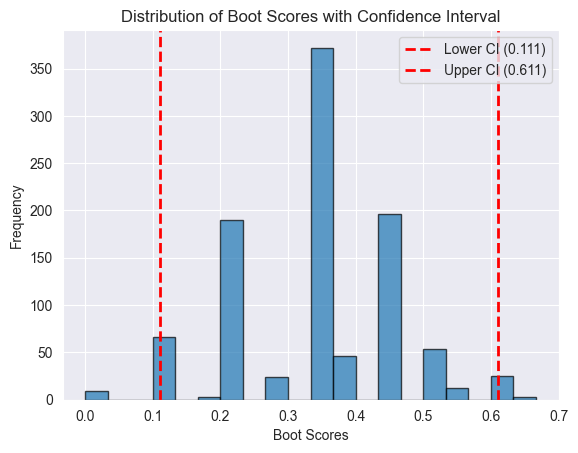

Bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 1165.52it/s]


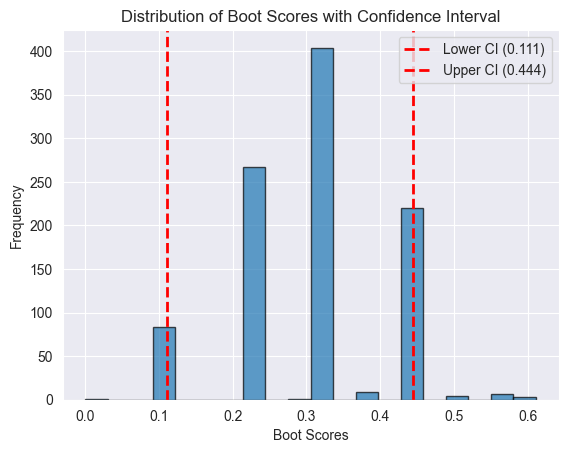

Bootstrapping: 100%|██████████| 1000/1000 [00:01<00:00, 695.12it/s]


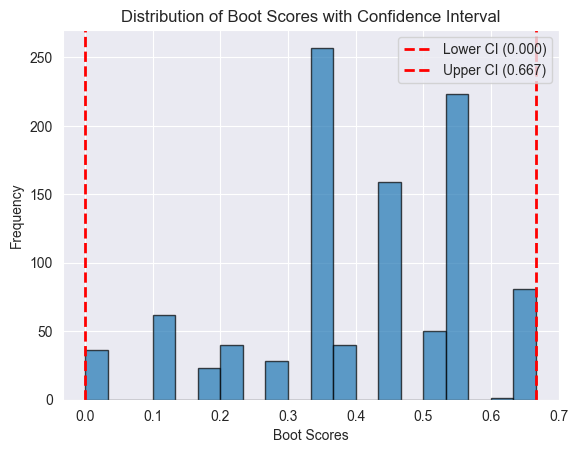

Bootstrapping: 100%|██████████| 1000/1000 [00:01<00:00, 660.34it/s]


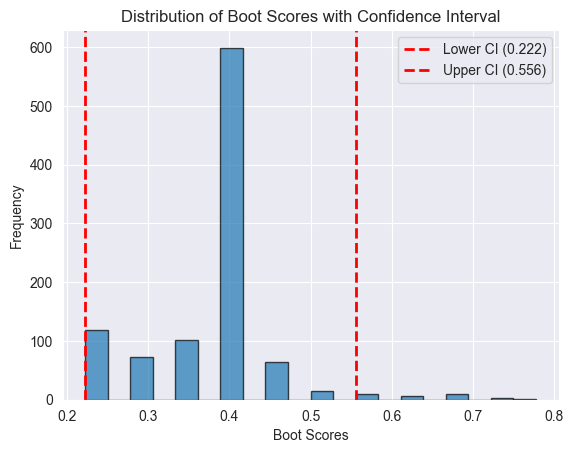

Bootstrapping: 100%|██████████| 1000/1000 [00:00<00:00, 1080.41it/s]


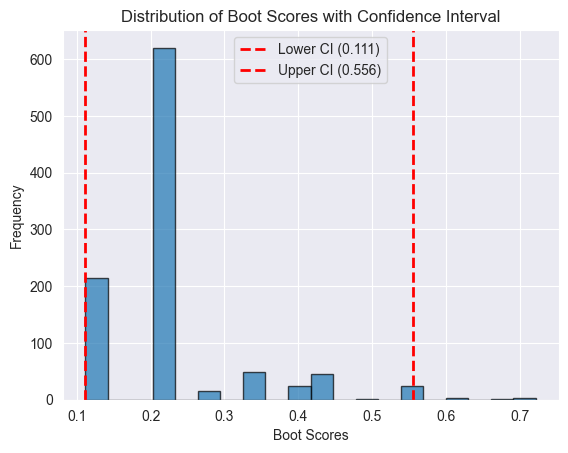

95% Confidence Interval for Cytokines Balanced Accuracy: 0.1111 - 0.6111
95% Confidence Interval for Cytometry Balanced Accuracy: 0.1111 - 0.4444
95% Confidence Interval for Clonal Breadth Balanced Accuracy: 0.0000 - 0.6667
95% Confidence Interval for Clonal Depth Balanced Accuracy: 0.2222 - 0.5556
95% Confidence Interval for RNN Balanced Accuracy: 0.1111 - 0.5556


In [323]:
def permutation_test(model, X_train, y_train, X_test, y_test, n_permutations=1000, random_state=None):
    """
    Performs a permutation test by training the model on the training set (with permuted labels)
    and evaluating it on the test set. Calculates the p-value based on the distribution of
    balanced accuracies from the permuted datasets.

    Parameters:
    - model: The machine learning model to evaluate.
    - X_train: Features of the training set.
    - y_train: Labels of the training set.
    - X_test: Features of the test set.
    - y_test: Labels of the test set.
    - n_permutations: Number of permutations to perform.
    - random_state: Seed for reproducibility.

    Returns:
    - p_value: The p-value from the permutation test.
    - observed_score: The observed balanced accuracy with true labels.
    - permuted_scores: Array of balanced accuracies from permuted labels.
    """
    rng = np.random.RandomState(random_state)
    
    # Step 1: Compute the observed performance using the true labels
    model_clone = clone(model)
    model_clone.fit(X_train, y_train)
    y_pred = model_clone.predict(X_test)
    observed_score = balanced_accuracy_score(y_test, y_pred)
    
    # Step 2: Permutation testing
    permuted_scores = []
    for _ in tqdm(range(n_permutations), desc="Permutation test"):
        # Shuffle the labels (y_train)
        y_permuted = shuffle(y_train, random_state=rng)
        
        # Clone and train the model on the permuted labels
        permuted_model = clone(model)
        permuted_model.fit(X_train, y_permuted)
        
        # Predict on the test set
        y_pred_perm = permuted_model.predict(X_test)
        
        # Calculate balanced accuracy and store it
        permuted_score = balanced_accuracy_score(y_test, y_pred_perm)
        permuted_scores.append(permuted_score)
    
    permuted_scores = np.array(permuted_scores)
    
    # Step 3: Calculate the p-value
    p_value = np.mean(permuted_scores >= observed_score)
    
    return p_value, observed_score, permuted_scores

def bootstrap_confidence_interval(model, X_train, y_train, X_test, y_test, n_bootstraps=1000, ci=95, random_state=None):
    """
    Estimates the confidence intervals for balanced accuracy using bootstrapping.
    The model is trained on bootstrapped samples of the training set and evaluated on a fixed test set.
    
    Parameters:
    - model: The machine learning model to evaluate.
    - X_train: Features of the training set.
    - y_train: Labels of the training set.
    - X_test: Features of the test set.
    - y_test: Labels of the test set.
    - n_bootstraps: Number of bootstrap samples.
    - ci: Confidence interval percentage (e.g., 95 for 95% CI).
    - random_state: Seed for reproducibility.
    
    Returns:
    - lower_bound: Lower bound of the confidence interval.
    - upper_bound: Upper bound of the confidence interval.
    - boot_scores: Array of balanced accuracies from each bootstrap sample.
    """
    rng = np.random.RandomState(random_state)
    boot_scores = []  # List to store scores from each bootstrap iteration
    
    for i in tqdm(range(n_bootstraps), desc="Bootstrapping"):
        # Step 1: Resample the training data with replacement
        X_resampled, y_resampled = resample(
            X_train, y_train, replace=True, random_state=rng.randint(0, 1e6)
        )
        
        # Ensure that both classes are present in the resampled labels
        if len(np.unique(y_resampled)) < 2:
            continue  # Skip this iteration if only one class is present
        
        # Step 2: Clone and train the model on the resampled training data
        model_clone = clone(model)
        model_clone.fit(X_resampled, y_resampled)
        
        # Step 3: Predict on the fixed test set
        y_pred = model_clone.predict(X_test)
        
        # Step 4: Calculate balanced accuracy and store it
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        boot_scores.append(bal_acc)
    
    boot_scores = np.array(boot_scores)
    
    # Step 5: Plot the bootstrapped scores and calculate the confidence intervals
    plot_boot_scores_with_ci(boot_scores, ci/100)
    
    # Step 6: Calculate confidence intervals
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(boot_scores, lower_percentile)
    upper_bound = np.percentile(boot_scores, upper_percentile)
    
    return lower_bound, upper_bound

p_val_cyto, observed_accuracy_cyto, permuted_scores_cyto = permutation_test(best_model_cyto, X_train_cyto_scaled, y_train_cyto, X_test_cyto_scaled, y_test_cyto, n_permutations=1000)
p_val_cytom, observed_accuracy_cytom, permuted_scores_cytom = permutation_test(best_model_cytom, X_train_cytom_scaled, y_train_cytom, X_test_cytom_scaled, y_test_cytom, n_permutations=1000)
p_val_cb, observed_accuracy_cb, permuted_scores_cb = permutation_test(best_model_cb, X_train_cb_scaled, y_train_cb, X_test_cb_scaled, y_test_cb, n_permutations=1000)
p_val_cd, observed_accuracy_cd, permuted_scores_cd = permutation_test(best_model_cd, X_train_cd_scaled, y_train_cd, X_test_cd_scaled, y_test_cd, n_permutations=1000)
p_val_rna , observed_accuracy_rna, permuted_scores_rna = permutation_test(best_model_rna, X_train_rna_scaled, y_train_rna, X_test_rna_scaled, y_test_rna, n_permutations=1000)

print_permutation_results("Cytokines", p_val_cyto, observed_accuracy_cyto, permuted_scores_cyto)
print_permutation_results("Cytometry", p_val_cytom, observed_accuracy_cytom, permuted_scores_cytom)
print_permutation_results("Clonal Breadth", p_val_cb, observed_accuracy_cb, permuted_scores_cb)
print_permutation_results("Clonal Depth", p_val_cd, observed_accuracy_cd, permuted_scores_cd)
print_permutation_results("RNN", p_val_rna, observed_accuracy_rna, permuted_scores_rna)

lower_cyto, upper_cyto = bootstrap_confidence_interval(best_model_cyto, X_train_cyto_scaled, y_train_cyto, X_test_cyto_scaled, y_test_cyto, n_bootstraps=1000, ci=95)
lower_cytom, upper_cytom = bootstrap_confidence_interval(best_model_cytom, X_train_cytom_scaled, y_train_cytom, X_test_cytom_scaled, y_test_cytom, n_bootstraps=1000, ci=95)
lower_cb, upper_cb = bootstrap_confidence_interval(best_model_cb, X_train_cb_scaled, y_train_cb, X_test_cb_scaled, y_test_cb, n_bootstraps=1000, ci=95)
lower_cd, upper_cd = bootstrap_confidence_interval(best_model_cd, X_train_cd_scaled, y_train_cd, X_test_cd_scaled, y_test_cd,n_bootstraps=1000, ci=95)
lower_rna, upper_rna = bootstrap_confidence_interval(best_model_rna, X_train_rna_scaled, y_train_rna, X_test_rna_scaled, y_test_rna, n_bootstraps=1000, ci=95)

print(f"95% Confidence Interval for Cytokines Balanced Accuracy: {lower_cyto:.4f} - {upper_cyto:.4f}")
print(f"95% Confidence Interval for Cytometry Balanced Accuracy: {lower_cytom:.4f} - {upper_cytom:.4f}")
print(f"95% Confidence Interval for Clonal Breadth Balanced Accuracy: {lower_cb:.4f} - {upper_cb:.4f}")
print(f"95% Confidence Interval for Clonal Depth Balanced Accuracy: {lower_cd:.4f} - {upper_cd:.4f}")
print(f"95% Confidence Interval for RNN Balanced Accuracy: {lower_rna:.4f} - {upper_rna:.4f}")

In [324]:
# Extract unique labels
unique_labels = list(set(value['name'] for value in LABELS.values()))

# Reorder the dictionary to move 'Model' to the front
model_column = list(results['Model'])

# Combine the results into a single dictionary
# List of models
model_names = [
    best_model_name_cyto,
    best_model_name_cytom,
    best_model_name_cb,
    best_model_name_cd,
    best_model_name_rna,
    'Consensus'
]
balance_methode = BALANCE if BALANCE else "Balanced"

# Initialize the combined_results_train with common columns
combined_results_train = {
    'Model': model_names,
    'LABELS': [', '.join(unique_labels)] * len(model_names),
    'COMPRESS_CORRELATED': [COMPRESS_CORRELATED] * len(model_names),
    'BALANCE_METHODE': [balance_methode]  * len(model_names),
    'OVERSAMPLING_METHOD': [OVERSAMPLING_METHOD] * len(model_names),
    'TRAIN Balanced_Accuracy': [
        train_metrics_cyto.get('Balanced_Accuracy'),
        train_metrics_cytom.get('Balanced_Accuracy'),
        train_metrics_cb.get('Balanced_Accuracy'),
        train_metrics_cd.get('Balanced_Accuracy'),
        train_metrics_rna.get('Balanced_Accuracy'),
        None  # For Consensus
    ],
    'TRAIN Accuracy': [
        train_metrics_cyto.get('Accuracy'),
        train_metrics_cytom.get('Accuracy'),
        train_metrics_cb.get('Accuracy'),
        train_metrics_cd.get('Accuracy'),
        train_metrics_rna.get('Accuracy'),
        None  # For Consensus
    ],
    'EVAL P-Value': [
        p_val_cyto,
        p_val_cytom,
        p_val_cb,
        p_val_cd,
        p_val_rna,
        None  # For Consensus
    ],
    'EVAL Permuted Scores Mean': [
        np.mean(permuted_scores_cyto),
        np.mean(permuted_scores_cytom),
        np.mean(permuted_scores_cb),
        np.mean(permuted_scores_cd),
        np.mean(permuted_scores_rna),
        None  # For Consensus
    ],
    'EVAL Permuted Scores Std Dev': [
        np.std(permuted_scores_cyto),
        np.std(permuted_scores_cytom),
        np.std(permuted_scores_cb),
        np.std(permuted_scores_cd),
        np.std(permuted_scores_rna),
        None  # For Consensus
    ],
    'EVAL CI Lower': [
        lower_cyto,
        lower_cytom,
        lower_cb,
        lower_cd,
        lower_rna,
        None  # For Consensus
    ],
    'EVAL CI Upper': [
        upper_cyto,
        upper_cytom,
        upper_cb,
        upper_cd,
        upper_rna,
        None  # For Consensus
    ],
}

# Identify all Precision, Recall, and F1 metric keys
# Assuming that the metric keys follow the pattern 'Precision_X', 'Recall_X', 'F1_X'
precision_keys = [key for key in train_metrics_cyto.keys() if key.startswith('Precision_')]
recall_keys = [key for key in train_metrics_cyto.keys() if key.startswith('Recall_')]
f1_keys = [key for key in train_metrics_cyto.keys() if key.startswith('F1_')]

# Function to add metrics to the combined_results_train dictionary
def add_metrics(metric_type, metric_keys):
    for key in metric_keys:
        column_name = f'TRAIN {metric_type}_{key.split("_")[1]}'
        combined_results_train[column_name] = [
            round(train_metrics_cyto.get(key), 4) if train_metrics_cyto.get(key) is not None else None,
            round(train_metrics_cytom.get(key), 4) if train_metrics_cytom.get(key) is not None else None,
            round(train_metrics_cb.get(key), 4) if train_metrics_cb.get(key) is not None else None,
            round(train_metrics_cd.get(key), 4) if train_metrics_cd.get(key) is not None else None,
            round(train_metrics_rna.get(key), 4) if train_metrics_rna.get(key) is not None else None,
            None  # For Consensus
        ]

add_metrics('Precision', precision_keys)
add_metrics('Recall', recall_keys)
add_metrics('F1', f1_keys)

combined_results_train_ = {'Data': model_column, **combined_results_train}

# Convert the dictionary to a DataFrame
df_train_results = pd.DataFrame(combined_results_train_)

# Round the numerical columns to 4 decimal places
numeric_columns = [
    'TRAIN Precision_0', 'TRAIN Recall_0', 'TRAIN F1_0', 'TRAIN Precision_1',
    'TRAIN Recall_1', 'TRAIN F1_1', 'TRAIN Balanced_Accuracy', 'TRAIN Accuracy', 'EVAL P-Value',
    'EVAL Permuted Scores Mean', 'EVAL Permuted Scores Std Dev', 'EVAL CI Lower', 'EVAL CI Upper'
]

df_train_results[numeric_columns] = df_train_results[numeric_columns].applymap(lambda x: round(x, 4) if isinstance(x, (int, float)) else x)
results_file = os.path.join(f'../data_created/best_models/{SAVE_DIR}', f"train_{SAVE_FILE}.csv")
df_train_results.to_csv(results_file, index=False)

combined_results_test = {
    'Model': [best_model_name_cyto, best_model_name_cytom, best_model_name_cb, best_model_name_cd, best_model_name_rna, 'Consensus'],
    'LABELS': [', '.join(unique_labels)] * 6,  # Add the unique labels to all rows
    'COMPRESS_CORRELATED': [COMPRESS_CORRELATED] * 6,  # Add COMPRESS_CORRELATED to all rows
    'OVERSAMPLING_METHOD': [OVERSAMPLING_METHOD] * 6,  # Add OVERSAMPLING_METHOD to all rows
    'BALANCE_METHODE': [balance_methode] * 6 ,
    **results.drop(['Model'], axis='columns'),
}
combined_results_test_ = {'Data': model_column, **combined_results_test}  # Add it back at the front


# Convert the dictionary to a DataFrame
df_test_results = pd.DataFrame(combined_results_test_)

results_file = os.path.join(f'../data_created/best_models/{SAVE_DIR}', f"test_{SAVE_FILE}.csv")
df_test_results.to_csv(results_file, index=False)


Processing SHAP for model: Cytokines
Computing SHAP values...
Top 10 SHAP features for Cytokines extracted successfully.

Processing SHAP for model: Cytometry
Computing SHAP values...
Top 10 SHAP features for Cytometry extracted successfully.

Processing SHAP for model: Clonal Breadth
Computing SHAP values...
Top 10 SHAP features for Clonal Breadth extracted successfully.

Processing SHAP for model: Clonal Depth
Computing SHAP values...
Top 10 SHAP features for Clonal Depth extracted successfully.

Processing SHAP for model: RNA Data
Computing SHAP values...
Top 10 SHAP features for RNA Data extracted successfully.

SHAP Feature Importances (Top 10 Features per Model):
             Model                          Feature  Importance
0        Cytokines                              MDC      0.4325
1        Cytokines                             VEGF      0.3608
2        Cytokines                      Flt3 Ligand      0.3420
3        Cytokines                             IL-8      0.3338
4

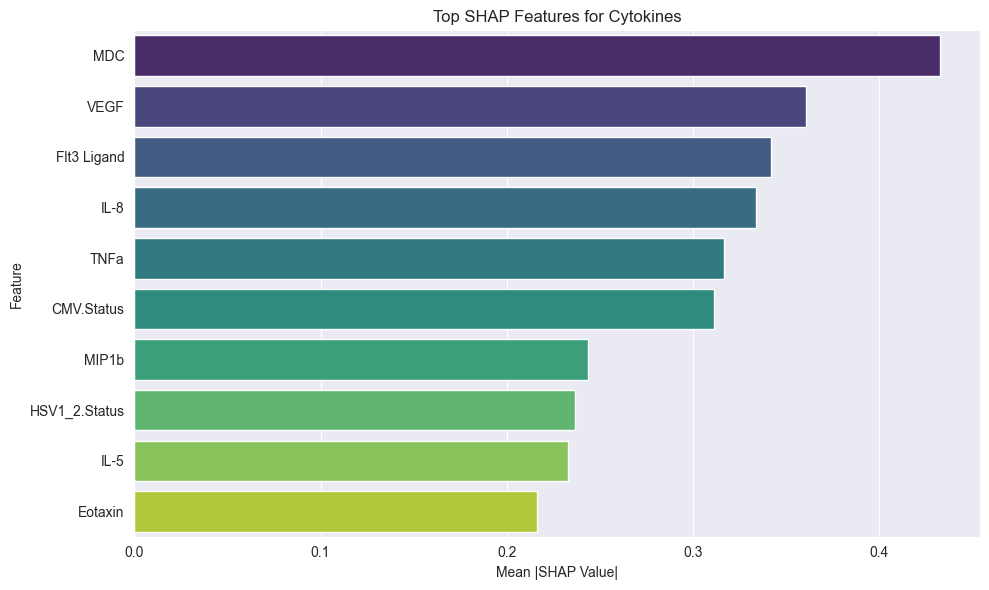

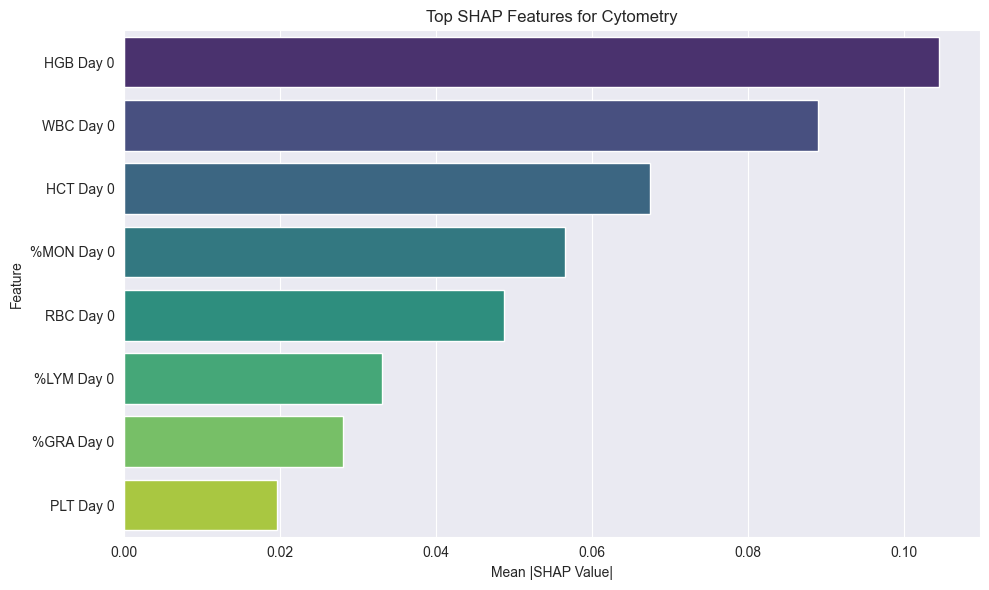

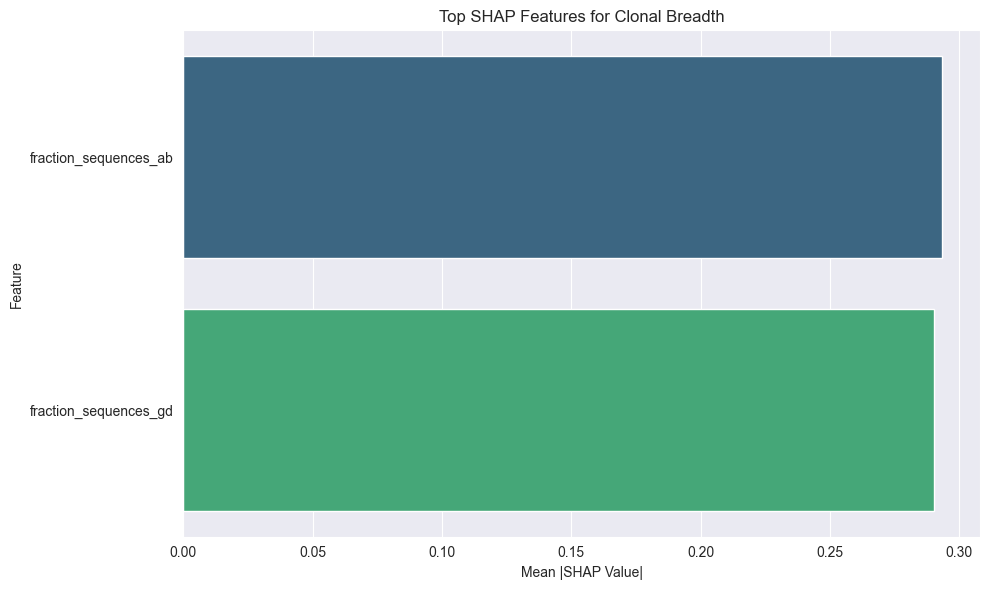

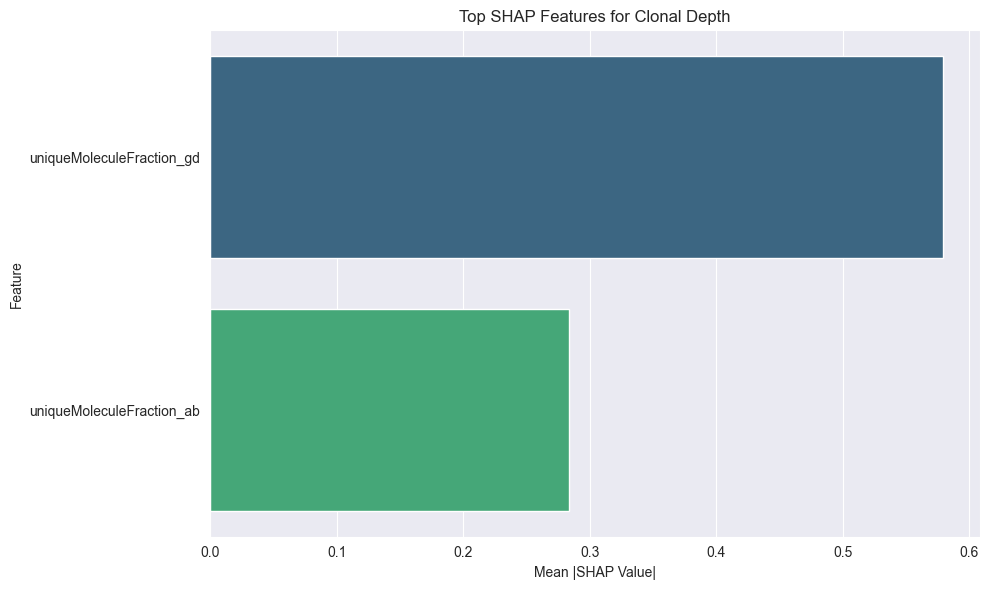

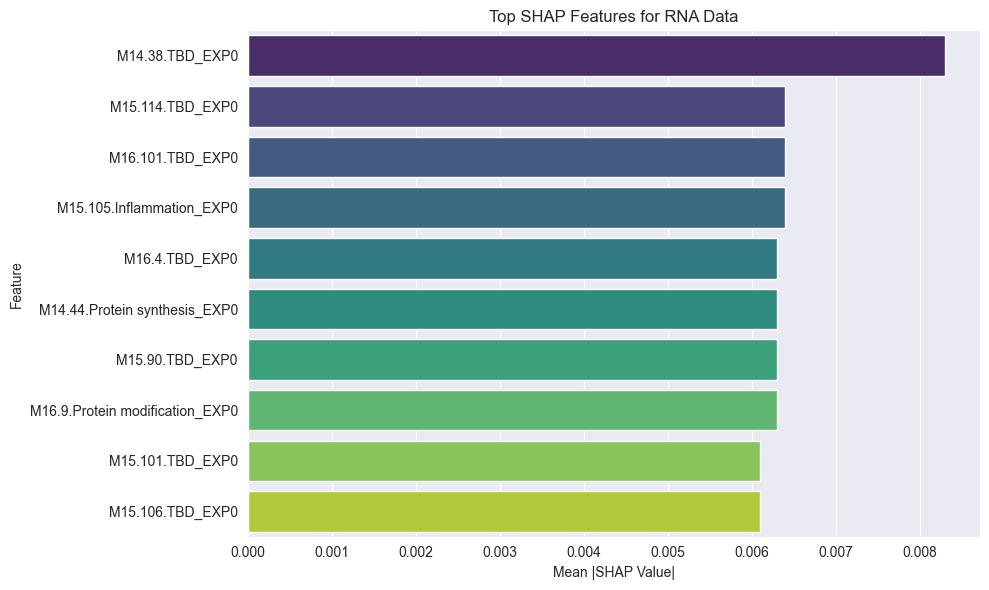

In [325]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Initialize SHAP's JavaScript visualization (optional, for notebook environments)
shap.initjs()

# Dictionary mapping model names to their trained instances, corresponding training data, and feature names
model_feature_map = {
    'Cytokines': (best_model_cyto, X_train_cyto_scaled, X_train_cyto.columns),
    'Cytometry': (best_model_cytom, X_train_cytom_scaled, X_train_cytom.columns),
    'Clonal Breadth': (best_model_cb, X_train_cb_scaled, X_train_cb.columns),
    'Clonal Depth': (best_model_cd, X_train_cd_scaled, X_train_cd.columns),
    'RNA Data': (best_model_rna, X_train_rna_scaled, X_train_rna.columns)
    # Add 'Consensus' if applicable, e.g.,
    # 'Consensus': (best_model_consensus, X_train_consensus_scaled, X_train_consensus_scaled.columns)
}

# Initialize a list to store SHAP feature importances for each model
shap_importances_list = []

# Iterate through each model in the map
for model_name, (model, X_train, feature_names) in model_feature_map.items():
    print(f"\nProcessing SHAP for model: {model_name}")
    
    # Verify the shape of X_train
    if X_train.ndim != 2:
        print(f"Error: X_train for {model_name} has incorrect shape {X_train.shape}. Expected 2D array.")
        shap_importances_list.append({
            'Model': model_name,
            'Feature': 'N/A',
            'Importance': 'N/A'
        })
        continue  # Skip to the next model
    
    # Determine the appropriate SHAP explainer based on model type
    if isinstance(model, (RandomForestClassifier, DecisionTreeClassifier)):
        explainer = shap.TreeExplainer(model)
    elif isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
    elif isinstance(model, GaussianNB):
        # Use a subset of training data for KernelExplainer to improve performance
        background = shap.sample(X_train, min(100, X_train.shape[0]), random_state=42)
        explainer = shap.KernelExplainer(model.predict_proba, background)
    elif isinstance(model, SVC):
        # For SVM models with probability=True
        background = shap.sample(X_train, min(100, X_train.shape[0]), random_state=42)
        explainer = shap.KernelExplainer(model.predict_proba, background)
    else:
        # Default to KernelExplainer for any other models
        background = shap.sample(X_train, min(100, X_train.shape[0]), random_state=42)
        explainer = shap.KernelExplainer(model.predict_proba, background)
    
    try:
        # Compute SHAP values without the 'nsamples' parameter
        print("Computing SHAP values...")
        shap_values = explainer(X_train)  # Removed nsamples=100
        
        # Handle multi-class vs binary classification
        if isinstance(shap_values, shap.Explanation):
            if shap_values.values.ndim == 3:
                # Multi-class classification: shap_values.values shape = (samples, features, classes)
                # Average the absolute SHAP values across classes
                shap_mean = np.abs(shap_values.values).mean(axis=2)
            elif shap_values.values.ndim == 2:
                # Binary classification or regression
                shap_mean = np.abs(shap_values.values)
            else:
                print(f"Unexpected SHAP values shape for {model_name}: {shap_values.values.shape}")
                shap_importances_list.append({
                    'Model': model_name,
                    'Feature': 'N/A',
                    'Importance': 'N/A'
                })
                continue  # Skip to the next model
        else:
            print(f"SHAP values for {model_name} are not of expected type.")
            shap_importances_list.append({
                'Model': model_name,
                'Feature': 'N/A',
                'Importance': 'N/A'
            })
            continue  # Skip to the next model
        
        # Convert SHAP mean values to a DataFrame
        shap_df = pd.DataFrame(shap_mean, columns=feature_names)
        
        # Calculate mean absolute SHAP value for each feature
        shap_importance = shap_df.mean().abs().sort_values(ascending=False).round(4)
        
        # Select top N features (e.g., top 10)
        top_n = 10
        top_features = shap_importance.head(top_n)
        
        # Append to the list
        for feature, importance in top_features.items():
            shap_importances_list.append({
                'Model': model_name,
                'Feature': feature,
                'Importance': importance
            })
        
        print(f"Top {top_n} SHAP features for {model_name} extracted successfully.")
    
    except Exception as e:
        print(f"Error processing model {model_name}: {e}")
        shap_importances_list.append({
            'Model': model_name,
            'Feature': 'N/A',
            'Importance': 'N/A'
        })

# Create a DataFrame from the SHAP importances list
df_shap_importances = pd.DataFrame(shap_importances_list)

# Display the SHAP Feature Importances DataFrame
print("\nSHAP Feature Importances (Top 10 Features per Model):")
print(df_shap_importances)

# Optionally, save the SHAP feature importances to a CSV file
results_file = os.path.join(f'../data_created/best_models/{SAVE_DIR}', f'shap_feature_{SAVE_FILE}.csv')
df_shap_importances.to_csv(results_file, index=False)

# Visualization Example: Bar Plot for Each Model
for model in df_shap_importances['Model'].unique():
    subset = df_shap_importances[df_shap_importances['Model'] == model].sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=subset, palette='viridis')
    plt.title(f'Top SHAP Features for {model}')
    plt.xlabel('Mean |SHAP Value|')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
